In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.optimize as spopt
import scipy.integrate as spint
import scipy.interpolate as spinterp
import pandas as pd

#### 1. 

*Approach:* In order to speed up the loading process, only relevant columns will be read. After removing all rows with NaNs in them, I select the stars that are members of NGC2506, and plot them in a color-color diagram.

In [2]:
# only load in relevant columns
col_list = ['plx', 'e_plx', 'Gmag', 'BP-RP', 'Cluster', 'PMemb']
gaia_raw =  pd.read_csv('cluster_members.txt', delim_whitespace=True, engine='python',
                        header=0, index_col=False, na_values='---', usecols=col_list)

In [3]:
display(gaia_raw)

,plx,e_plx,Gmag,BP-RP,PMemb,Cluster
0,2.1358,0.0393,14.804825,1.412944,0.7,Alessi_10
1,2.2071,0.1376,17.350530,2.605459,1.0,Alessi_10
2,2.0438,0.0572,12.473157,0.865277,0.8,Alessi_10
3,2.3256,0.0933,16.400896,1.935030,1.0,Alessi_10
4,2.2585,0.1093,17.435835,2.370981,1.0,Alessi_10
...,...,...,...,...,...,...
401443,0.1927,0.0799,16.845219,2.411852,0.9,Westerlund_2
401444,0.1374,0.1114,17.515165,2.518133,0.9,Westerlund_2
401445,0.1898,0.0316,14.545496,2.029756,1.0,Westerlund_2
401446,0.3787,0.0326,12.339190,0.426735,0.6,Westerlund_2


In [4]:
# remove all stars with NaN values
gaia_clean = gaia_raw[:].dropna(how="any")
print(gaia_clean.shape)

(395785, 6)


In [5]:
# choose only stars which are for sure members of the cluster
NGC2506 = gaia_clean[gaia_clean.Cluster=='NGC_2506']
NGC2506 = NGC2506[NGC2506.PMemb==1]
print(NGC2506.shape)

(1145, 6)


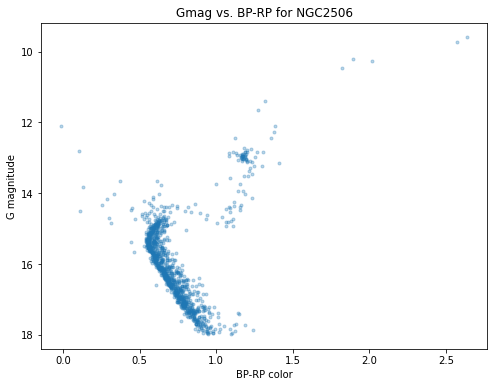

In [6]:
# plot color-color diagram
fig = plt.figure(figsize=(8,6))
plt.scatter(NGC2506['BP-RP'], NGC2506.Gmag,  marker='.', alpha=0.3)
plt.gca().invert_yaxis()
plt.title('Gmag vs. BP-RP for NGC2506')
plt.ylabel('G magnitude')
plt.xlabel('BP-RP color')
plt.show()

*Conclusion:* 
Here we can clearly see the stars in the cluster that are still in the MS stage, as well as some stars that have turned-off the MS, and are moving towards, or ar at the RGB. A few blue stragglers are also visible on the leftmost part of the diagram.

#### 2.

*Approach:* First, I plot the parallax vs. the Gmag. To get their correlation, I run two correlation tests, Pearson's r and Spearman's rho (see assumptions bellow). Pearson's r will test for linear correlation in the data, while Spearman's rho will check if the data are monotonically related. Together, these two values should give reasonable evidence for the correlation or non-correlation of the data.

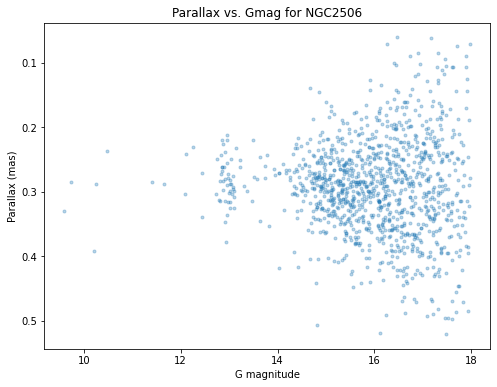

In [7]:
fig = plt.figure(figsize=(8,6))
plt.scatter(NGC2506.Gmag, NGC2506.plx, marker='.', alpha=0.3)
plt.gca().invert_yaxis()
plt.title('Parallax vs. Gmag for NGC2506')
plt.xlabel('G magnitude')
plt.ylabel('Parallax (mas)')
plt.show()

*Explanation:* The reason for the inverted cone shape is that there are more small stars (weaker G magnitude) than heavy stars, following the IMF. Thus there are more stars on the right side of the diagram than ont he left. Furthermore, lighter stars live longer than heavy stars, and so have more time to drift away from the cluster's center before they die. Hence we see more stars that are further from the center on the light (right) side of the diagram than on the heavy (left) side. This explains the cone shape. Furthermore, dimmer values might carry a greater measurement uncertainty, so that can contribute to the cone shape as well.

In [8]:
def correl_stats(data_a, data_b, only_r=False):
    '''Runs Pearson's r and Spearman's rho tests on provided data'''
    (rcor, rpval) = sps.pearsonr(data_a, data_b)
    (rhocor, rhopval) = sps.spearmanr(data_a, data_b)
    
    print(f"Pearson's r and p-value: {rcor}, {rpval}")
    if not only_r:
        print(f"Spearman's rho and p-value: {rhocor}, {rhopval}")

*Assumptions:* Both the G magnitude and the parallaxes are independent and identically distributed. However, they are not exactly identically distributed, since the variance of the parallax seem to be dependent on the Gmag (as previously discussed, the parallax spread becomes higher for higher Gmag). However, the data clearly belong to one population, not two, and the distribution is just cone-shaped. Thus we can make the assumptions, keeping this in mind.

In [9]:
# Null hypothesis: The Gmag and paralax for the cluster are not correlated
# Recquired: p > 0.05 for both tests

correl_stats(NGC2506.Gmag, NGC2506.plx)

Pearson's r and p-value: 0.026825933692502562, 0.36445776827446136
Spearman's rho and p-value: 0.04153825850873356, 0.16012945023860628


The p value is higher than recquired for both tests, thus the null hypothesis cannot be rejected. There is no correlation between the Gmag and the parallax. 

#### 3.

*Approach:* Create a function similar to that of Week 1A's assignment for calculating the value of gravity from the period of the pendulum. However, instead of having the value of gravity and the period as parameters, here we use the distance and the paralax. Also, to create the p_array, we apply the $p=1/d$ formula.

In [10]:
# correction for zero-point offset
NGC2506.plx += 0.029

In [11]:
def calc_posterior(plxs, errors_p, d_range):
    '''Calculates posterior distribution of supplied paralaxes and errors. Also plots 1-sigma confidence interval'''
    # distance range to calculate posterior for (in kpc)
    d_i, d_f = d_range[0], d_range[1] #3., 3.3
    # parameter array
    d_array = np.linspace(d_i, d_f, 5000)
    p_array = 1/d_array
    
    # prior is uniform distribution
    prior = 1/(d_f-d_i)
    
    # distribution of measurements from normal with error as sigma
    d_dist = sps.norm(loc=p_array.reshape(len(p_array),1), scale=errors_p)

    # in order to take product, we add logs in order to avoid problems of division by 0
    log_likel_prior = np.sum(np.log(d_dist.pdf(plxs)), axis=1) + np.log(prior)
    likel_prior = np.exp(log_likel_prior-np.amax(log_likel_prior))
    likel_prior_int = spint.simpson(likel_prior, d_array, axis=0)

    posterior_pdf = likel_prior/likel_prior_int
    # for calculating confidence intervals
    posterior_cdf = spint.cumulative_trapezoid(posterior_pdf, d_array ,initial=0)
    posterior_ppf = spinterp.interp1d(posterior_cdf, d_array)

    int68 = posterior_ppf([0.159, 0.841])
    print('Distance in kpc:', d_array[np.argmax(posterior_pdf)], 'with 1-sig interval:', int68)
    
    plt.figure()
    plt.plot(d_array, posterior_pdf)
    plt.vlines(int68,ymin=0,ymax=np.amax(posterior_pdf),color='black',linestyle='dotted')
    plt.xlabel('Distance (kpc)',fontsize=12)
    plt.ylabel(r'Posterior density',fontsize=12)
    plt.show()

Distance in kpc: 3.134126825365073 with 1-sig interval: [3.11901443 3.14964146]


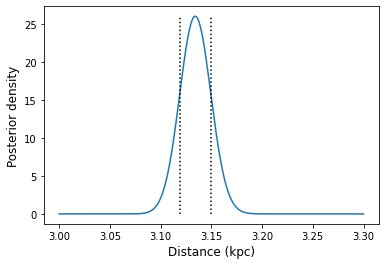

In [12]:
calc_posterior(NGC2506.plx, NGC2506.e_plx, [3,3.3])

#### 4.

*Approach:* Pick a cluster with a high number of stars (and that looks pretty in the color-color plot), and find the distance from the posterior distribution. With this distance, find the absolute magnitude, and plot it together with NGC2506 in a color-color diagram.

In [13]:
clusters = set(gaia_clean.Cluster)
print(clusters)

{'Mayer_3', 'NGC_2849', 'NGC_3960', 'FSR_0942', 'FSR_1253', 'Kronberger_84', 'Koposov_43', 'Melotte_105', 'Berkeley_35', 'FSR_1460', 'Trumpler_33', 'NGC_2225', 'Ivanov_4', 'NGC_366', 'NGC_3114', 'Berkeley_75', 'NGC_1039', 'BH_150', 'NGC_7128', 'Collinder_307', 'NGC_2269', 'NGC_1528', 'FSR_0088', 'Gulliver_47', 'Berkeley_68', 'Alessi_20', 'DBSB_21', 'NGC_7024', 'NGC_6633', 'FSR_0923', 'Ruprecht_144', 'Czernik_25', 'NGC_2421', 'Kronberger_85', 'Gulliver_57', 'ASCC_71', 'NGC_5281', 'Gulliver_20', 'ASCC_114', 'NGC_6611', 'Teutsch_144', 'NGC_4349', 'FSR_0167', 'Teutsch_11', 'NGC_2168', 'ESO_130_08', 'Roslund_7', 'Berkeley_91', 'King_9', 'NGC_6322', 'Trumpler_12', 'King_6', 'Czernik_41', 'NGC_2302', 'ESO_559_13', 'Berkeley_89', 'NGC_6802', 'Gulliver_37', 'Gulliver_13', 'FSR_1315', 'Stock_14', 'IC_2391', 'NGC_2422', 'NGC_2818', 'Ruprecht_117', 'DC_8', 'NGC_3228', 'FSR_1521', 'FSR_0198', 'BH_54', 'Gulliver_4', 'Markarian_38', 'Berkeley_23', 'NGC_381', 'NGC_5381', 'Skiff_J2330+60.2', 'Czernik_8

In [14]:
cluster_2 = gaia_clean[gaia_clean.Cluster=='NGC_3114']
cluster_2 = cluster_2[cluster_2.PMemb==1]
print(cluster_2.shape)
# zero-point offset correction
cluster_2.plx += 0.029

(696, 6)


Distance in kpc: 1.014870974194839 with 1-sig interval: [1.0138893  1.01585665]


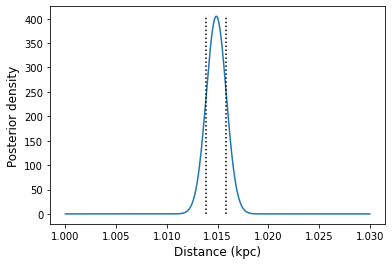

In [15]:
calc_posterior(cluster_2.plx, cluster_2.e_plx, [1, 1.03])

In [16]:
def absolute_mag(apparent_mag, dist):
    '''Convert from apparent magnitude to absolute magnitude at distance in kpc'''
    M = apparent_mag - 5*np.log10(dist) - 10
    return M

In [17]:
# turn visual magnitudes to absolute magnitudes, using the distance obtained from the posterior distribution
NGC2506_abs = absolute_mag(NGC2506.Gmag, 3.134126825365073)
cluster_2_abs = absolute_mag(cluster_2.Gmag, 1.014870974194839)

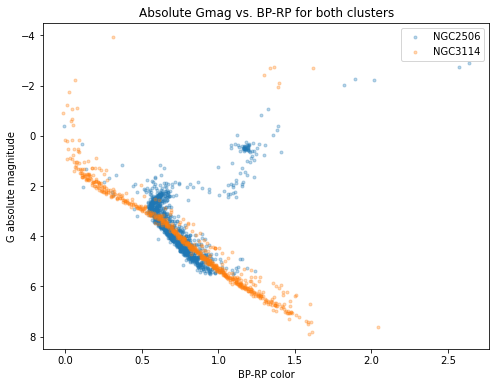

In [18]:
fig = plt.figure(figsize=(8,6))
plt.scatter(NGC2506['BP-RP'], NGC2506_abs,  marker='.', alpha=0.3, label='NGC2506')
plt.scatter(cluster_2['BP-RP'], cluster_2_abs,  marker='.', alpha=0.3, label='NGC3114')
plt.gca().invert_yaxis()
plt.title('Absolute Gmag vs. BP-RP for both clusters')
plt.ylabel('G absolute magnitude')
plt.xlabel('BP-RP color')
plt.legend()
plt.show()

Here we see that the two clusters compared are at different stages of their evolution. NGC 3114 is younger than NGC2506, since its heavier stars are still in their MS stage.